In [89]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime
from numexpr import evaluate
import os

In [90]:
def get_mask(N):
    mask = np.zeros((N,N),dtype=bool)
    mask[0,:]  = True
    mask[-1,:] = True
    mask[:,0]  = True
    mask[:,-1] = True
    mask[int(N/4):int(N*9/32),:N-1] = True
    mask[1:N-1,int(N*5/16):int(N*3/8)] = False
    mask[1:N-1,int(N*5/8):int(N*11/16)] = False

    return mask

In [91]:
def get_initial_U(N, mask):
    U = np.zeros((N,N))
    U[mask] = 0
    return U

In [92]:
def save_output_figure():
    current_directory = os.getcwd()
    relative_path = 'output/'
    output_directory = os.path.join(current_directory, relative_path)
    os.makedirs(output_directory, exist_ok=True)

    now = datetime.now()
    current_time = now.strftime("%H%M%S")
    filename = 'finitedifference' + current_time +'.png'

    save_path = os.path.join(output_directory, filename)
    plt.savefig(save_path, dpi=240)

In [93]:
def get_Unew_default(U, ULX, URX, ULY, URY, fac):
    laplacian = (ULX + ULY - 4*U + URX + URY)
    return (2*U - Uprev + fac * laplacian)

In [94]:
def get_Unew_numexpr(U, ULX, URX, ULY, URY, fac):
    laplacian = evaluate("ULX + ULY - 4*U + URX + URY")
    return evaluate("2*U - Uprev + fac * laplacian")

In [95]:
def get_Unew_numexpr2(U, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)")

In [96]:
def get_Unew_numexpr3(U, ULX, URX, ULY, URY, fac):
    return evaluate("2*U - Uprev + fac * (ULX + ULY - 4*U + URX + URY)", optimization='aggressive')

In [97]:
def get_Unew_numexpr4(U, Uprev, intermediate, fac):
    return evaluate("2*U - Uprev + fac * intermediate")

In [98]:
def simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew):
    t = 0
    U_local = U.copy()

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:
        #print(t)
        # === Compute Laplacian ===
        ULX = np.roll(U_local, L, axis=aX)
        URX = np.roll(U_local, R, axis=aX)
        ULY = np.roll(U_local, L, axis=aY)
        URY = np.roll(U_local, R, axis=aY)
            
        # === Update U ===
        Unew = get_Unew(U_local, ULX, URX, ULY, URY, fac)
        Uprev = 1.*U
        U_local = 1.*Unew
        
        # === Apply boudary conditions (Dirichlet/inflow) ===
        U_local[mask] = 0
        U_local[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2
        
        # === Update time ===
        t += dt
        
        # if (plotRealTime) or t >= tEnd:
        # 	plot_U(U, mask, cmap)
        
    return U

In [99]:
# Does not work because numExpr does not handle numpy function calls
def simulate_finite_difference_final(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew):
    t = 0

    # === Initialize Mesh ===
    dx = boxsize / N
    dt = (np.sqrt(2)/2) * dx / c
    fac = dt**2 * c**2 / dx**2
    aX = 0   # x-axis
    aY = 1   # y-axis
    R = -1   # right
    L = 1    # left

    # === Initialize grid ===
    xlin = np.linspace(0.5 * dx, boxsize - 0.5*dx, N)

    # === Main simulation loop ===
    while t < tEnd:
        
        intermediate = evaluate("(np.roll(U_local, L, axis=aX) + np.roll(U_local, L, axis=aY) - 4*U + np.roll(U_local, R, axis=aX) + np.roll(U_local, R, axis=aY))")
        
        # === Update U ===
        Unew = get_Unew(U, Uprev, intermediate, fac)
        Uprev = 1.*U
        U = 1.*Unew
        
        # === Apply boudary conditions (Dirichlet/inflow) ===
        U[mask] = 0
        U[0,:] = np.sin(20*np.pi*t) * np.sin(np.pi*xlin)**2
        
        # === Update time ===
        t += dt
        
        # if (plotRealTime) or t >= tEnd:
        # 	plot_U(U, mask, cmap)
        
    return U

In [100]:
from timeit import default_timer as timer

""" Finite Difference simulation """

# === Simulation parameters ===
boxsize        = 1.    # Size of the box
c              = 1.    # Wave Speed
tEnd           = 2.    # Simulation time
plotRealTime   = False  # Set to True for real-time vizualisation

resolutions = [100 * i for i in range(1, 7)]

results_default = []
results_numexpr = []
results_numexpr2 = []
results_numexpr3 = []
results_numexpr4 = []

for N in resolutions:
    print("N = " + str(N))
    # === Generate mask & initial conditions
    mask = get_mask(N)
    U = get_initial_U(N, mask)
    Uprev = 1.*U

    start = timer()
    res1 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_default)
    end = timer()

    results_default.append(end - start)
    
    start = timer()
    res2 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr)
    end = timer()

    results_numexpr.append(end - start)
    
    start = timer()
    res3 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr2)
    end = timer()

    results_numexpr2.append(end - start)
    
    start = timer()
    res4 = simulate_finite_difference(U, Uprev, mask, boxsize, N, c, tEnd, plotRealTime, get_Unew_numexpr3)
    end = timer()

    results_numexpr3.append(end - start)
    
    # Making sure that the modified implementation match the original one
    np.testing.assert_allclose(res2, res1)
    np.testing.assert_allclose(res3, res1)
    np.testing.assert_allclose(res4, res1)

N = 100
N = 200
N = 300
N = 400


/tmp/ipykernel_135716/2836354031.py:2: RuntimeWarning: overflow encountered in multiply
  laplacian = (ULX + ULY - 4*U + URX + URY)
/tmp/ipykernel_135716/2836354031.py:2: RuntimeWarning: invalid value encountered in subtract
  laplacian = (ULX + ULY - 4*U + URX + URY)
/tmp/ipykernel_135716/2836354031.py:2: RuntimeWarning: invalid value encountered in add
  laplacian = (ULX + ULY - 4*U + URX + URY)
/tmp/ipykernel_135716/2836354031.py:3: RuntimeWarning: overflow encountered in multiply
  return (2*U - Uprev + fac * laplacian)
/tmp/ipykernel_135716/2836354031.py:3: RuntimeWarning: invalid value encountered in add
  return (2*U - Uprev + fac * laplacian)
/tmp/ipykernel_135716/2836354031.py:2: RuntimeWarning: overflow encountered in add
  laplacian = (ULX + ULY - 4*U + URX + URY)


N = 500
N = 600


1.301149267730744
1.5318223842548664
1.530067537955692


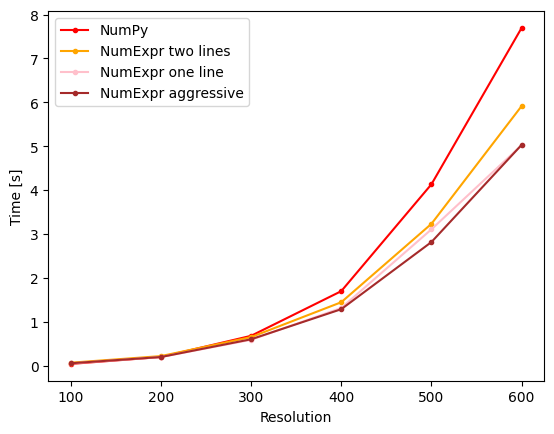

In [101]:
def get_points_xy(resolutions, results):
    points = []

    for i in range(len(resolutions)):
        points.append([resolutions[i], results[i]])
    
        
    data = np.array([points])
    x, y = data.T
    
    return [x, y]

x, y = get_points_xy(resolutions, results_default)
plt.plot(x, y, color="red", marker='.', label="python")

x_c, y_c = get_points_xy(resolutions, results_numexpr)
plt.plot(x_c, y_c, color="orange", marker='.', label="numexpr")

x_c, y_c = get_points_xy(resolutions, results_numexpr2)
plt.plot(x_c, y_c, color="pink", marker='.', label="numexpr 2")

x_c, y_c = get_points_xy(resolutions, results_numexpr3)
plt.plot(x_c, y_c, color="brown", marker='.', label="numexpr 3")

print(results_default[-1]/results_numexpr[-1])
print(results_default[-1]/results_numexpr2[-1])
print(results_default[-1]/results_numexpr3[-1])

plt.xlabel('Resolution')
plt.ylabel('Time [s]')
plt.legend(['NumPy','NumExpr two lines', 'NumExpr one line', 'NumExpr aggressive']) 
plt.show()